<a href="https://colab.research.google.com/github/GAIPGroup14/Project/blob/main/Noicemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [618]:
from nltk import word_tokenize
from collections import defaultdict

In [619]:
num_labels = 10

In [620]:
def count_top_x_words(corpus, top_x, skip_top_n):
    count = defaultdict(lambda: 0)
    for c in corpus:
        for w in word_tokenize(c):
            count[w] += 1
    count_tuples = sorted([(w, c) for w, c in count.items()], key=lambda x: x[1], reverse=True)
    return [i[0] for i in count_tuples[skip_top_n: skip_top_n + top_x]]

In [621]:
def replace_top_x_words_with_vectors(corpus, top_x):
    topx_dict = {top_x[i]: i for i in range(len(top_x))}

    return [
        [topx_dict[w] for w in word_tokenize(s) if w in topx_dict]
        for s in corpus
    ], topx_dict

In [622]:
def filter_to_top_x(corpus, n_top, skip_n_top=0):
    top_x = count_top_x_words(corpus, n_top, skip_n_top)
    return replace_top_x_words_with_vectors(corpus, top_x)

In [623]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

In [624]:
import nltk
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

In [625]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [626]:
#reading data from csv file
#this file should contain the test data
df1 = pd.read_csv('/content/drive/MyDrive/Final_cleaned_data/20000_cleaned_data.csv')
df1.head()

,provision,label,source
0,Section and Subsection headings in this Amendm...,"[""headings""]",2019/QTR1/000119312519044328/d691151dex101.htm
1,THIS AMENDMENT AND THE RIGHTS AND OBLIGATIONS ...,"[""applicable laws""]",2019/QTR1/000119312519044328/d691151dex101.htm
2,This Amendment may be executed in any number o...,"[""counterparts""]",2019/QTR1/000119312519044328/d691151dex101.htm
3,The execution and delivery of this Amendment b...,"[""binding effects""]",2019/QTR1/000119312519044328/d691151dex101.htm
4,Each of the parties hereto irrevocably waives ...,"[""waiver of jury trials""]",2019/QTR1/000119312519044328/d691151dex101.htm


In [627]:
#setting up top ten labels for the data
counter = Counter(df1['label'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common(num_labels))}
df1 = df1[df1['label'].map(lambda x: x in top_10_varieties)]
df1.head()

,provision,label,source
0,Section and Subsection headings in this Amendm...,"[""headings""]",2019/QTR1/000119312519044328/d691151dex101.htm
2,This Amendment may be executed in any number o...,"[""counterparts""]",2019/QTR1/000119312519044328/d691151dex101.htm
60,All notices under this Agreement must be given...,"[""notices""]",2019/QTR1/000110465919016051/a19-6809_1ex10d2.htm
61,"The validity, interpretation, construction and...","[""governing laws""]",2019/QTR1/000110465919016051/a19-6809_1ex10d2.htm
62,If any provision of this Agreement or the appl...,"[""severability""]",2019/QTR1/000110465919016051/a19-6809_1ex10d2.htm


In [628]:
#creating the description list and mapped word list
#the mapped list and word list created from the different columns
description_list = df1['provision'].tolist()
mapped_list, word_list = filter_to_top_x(description_list, 2500,num_labels)
varietal_list_o = [top_10_varieties[i] for i in df1['label'].tolist()]
varietal_list = to_categorical(varietal_list_o)
# print(mapped_list)
# print(word_list, varietal_list)

In [629]:
#The train, test split for the given data
#padding the list for data
max_review_length = 150
mapped_list = sequence.pad_sequences(mapped_list, maxlen=max_review_length)
train_x1, test_x1, train_y1, test_y1 = train_test_split(mapped_list, varietal_list, test_size=0.3)

In [630]:
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(2500, embedding_vector_length, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [631]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 150, 64)           160000    
                                                                 
 flatten_38 (Flatten)        (None, 9600)              0         
                                                                 
 dense_77 (Dense)            (None, 256)               2457856   
                                                                 
 dense_78 (Dense)            (None, 10)                2570      
                                                                 
Total params: 2,620,426
Trainable params: 2,620,426
Non-trainable params: 0
_________________________________________________________________


In [632]:
history = model.fit(train_x1, train_y1, epochs=10, batch_size=500, validation_data=(test_x1, test_y1))

Epoch 1/10
3/3 [==============================] - 1s 260ms/step - loss: 0.0885 - accuracy: 0.1690 - val_loss: 0.0868 - val_accuracy: 0.1912
Epoch 2/10
3/3 [==============================] - 1s 198ms/step - loss: 0.0860 - accuracy: 0.3060 - val_loss: 0.0845 - val_accuracy: 0.3517
Epoch 3/10
3/3 [==============================] - 1s 192ms/step - loss: 0.0830 - accuracy: 0.4318 - val_loss: 0.0818 - val_accuracy: 0.3938
Epoch 4/10
3/3 [==============================] - 1s 200ms/step - loss: 0.0787 - accuracy: 0.4534 - val_loss: 0.0776 - val_accuracy: 0.4376
Epoch 5/10
3/3 [==============================] - 1s 192ms/step - loss: 0.0730 - accuracy: 0.4937 - val_loss: 0.0719 - val_accuracy: 0.5122
Epoch 6/10
3/3 [==============================] - 1s 203ms/step - loss: 0.0651 - accuracy: 0.6001 - val_loss: 0.0647 - val_accuracy: 0.5608
Epoch 7/10
3/3 [==============================] - 1s 194ms/step - loss: 0.0561 - accuracy: 0.6544 - val_loss: 0.0566 - val_accuracy: 0.6370
Epoch 8/10
3/3 [====

In [633]:
#Storing the test predict data
y_test1 = model.predict(train_x1)
#print(y_test1)

In [634]:
#Calculating and identifying the correct predcition
y_score1 = model.predict(train_x1)

# to use train data : train_x1 
#for test data: test_x1
y_score1 = [[1 if i == max(sc) else 0 for i in sc] for sc in y_score1]
n_right = 0

for i in range(len(y_score1)):
  #If you used train data : train_y1
  #If you used test data : test_y1
    if all(y_score1[i][j] == train_y1[i][j] for j in range(len(y_score1[i]))):
        n_right += 1

In [635]:
#creating a list of labels
list_labels = []
for dict in top_10_varieties:
      list_labels.append(dict)

In [636]:
#printing labels
for i in range(len(y_score1)):
  for j in range(len(y_score1[i])):
    if( y_score1[i][j]== 1): 
      print(description_list[j], list_labels[j])
      print("\n")
  # else:
  #    print("no") 

In the event that any provision of this Agreement would be held in any jurisdiction to be invalid, prohibited or unenforceable for any reason, such provision, as to such jurisdiction, shall be ineffective, without invalidating the remaining provisions of this Agreement or affecting the validity or enforceability of such provision in any other jurisdiction. Notwithstanding the foregoing, if such provision could be more narrowly drawn so as not to be invalid, prohibited or unenforceable in such jurisdiction, it shall, as to such jurisdiction, be so narrowly drawn, without invalidating the remaining provisions of this Agreement or affecting the validity or enforceability of such provision in any other jurisdiction. ["taxes"]


All notices under this Agreement must be given in writing by personal delivery or United States registered or certified mail, return receipt requested, at the addresses indicated in this Agreement, or any other address designated in writing by either party. ["severa

In [637]:
#printing accuracy
print("Accuracy: %.2f%%" % ((n_right/float(len(train_x1)) * 100)))

Accuracy: 87.13%


In [638]:
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

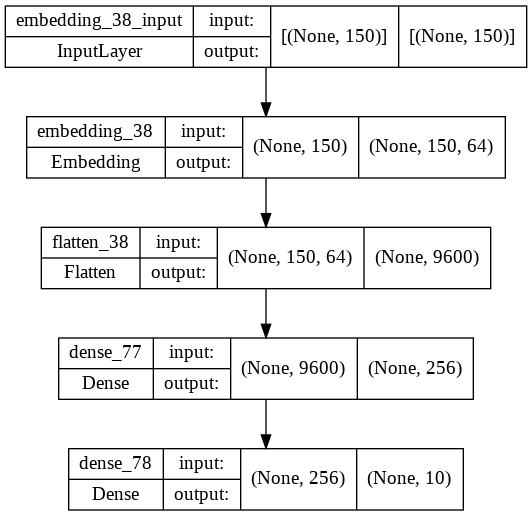

In [639]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

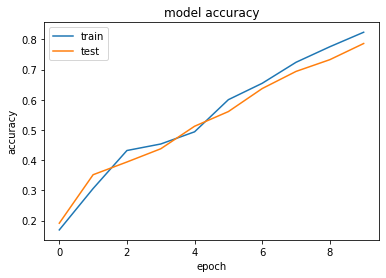

In [640]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

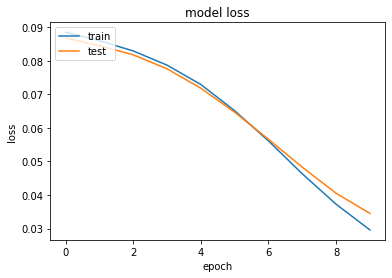

In [641]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [642]:
model.save("77.61_accuracy.h5")

In [617]:
from google.colab import drive
drive.mount('/content/drive')

#reading data from csv file
#this file should contain the test data
df = pd.read_csv('/content/drive/MyDrive/Final_cleaned_data/500_live_test.csv')

#setting up top ten labels for the data
counter = Counter(df['label'].tolist())
top_10_varieties = {i[0]: idx for idx, i in enumerate(counter.most_common(num_labels))}
df = df[df['label'].map(lambda x: x in top_10_varieties)]


#creating the description list and mapped word list
#the mapped list and word list created from the different columns
description_list = df['provision'].tolist()
mapped_list, word_list = filter_to_top_x(description_list, 2500, num_labels)
varietal_list_o = [top_10_varieties[i] for i in df['label'].tolist()]
varietal_list = to_categorical(varietal_list_o)
#print(mapped_list)
#print(word_list, varietal_list)

#The train, test split for the given data
#padding the list for data
mapped_list = sequence.pad_sequences(mapped_list, maxlen=max_review_length)
train_x, test_x, train_y, test_y = train_test_split(mapped_list, varietal_list, test_size=0.3)

#Storing the test predict data
y_test = model.predict(train_x)
#print(y_test1)

#Calculating and identifying the correct predcition
y_score = model.predict(train_x)
# to use train data : train_x1 
#for test data: test_x1
y_score = [[1 if i == max(sc) else 0 for i in sc] for sc in y_score]
n_right = 0
for i in range(len(y_score)):
  #If you used train data : train_y
  #If you used test data : test_y
    if all(y_score[i][j] == train_y[i][j] for j in range(len(y_score[i]))):
        n_right += 1

#creating a list of labels
list_labels = []
for dict in top_10_varieties:
      list_labels.append(dict)   

#printing labels
for i in range(len(y_score)):
  for j in range(len(y_score[i])):
    if( y_score[i][j]== 1): 
      print(description_list[j], list_labels[j])
      print("\n")
  # else:
  #    print("no") 

#printing accuracy
print("Accuracy: %.2f%%" % ((n_right/float(len(test_x)) * 100)))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All covenants, agreements, representations and warranties made by the Loan Parties in the Loan Documents and in the certificates or other instruments delivered in connection with or pursuant to this Agreement or any other Loan Document shall be considered to have been relied upon by the other parties hereto and shall survive the execution and delivery of the Loan Documents and the making of any Loans and issuance of any Letters of Credit, regardless of any investigation made by any such other party or on its behalf and notwithstanding that the Administrative Agent, any Issuing Bank or any Lender may have had notice or knowledge of any Default or incorrect representation or warranty at the time any credit is extended hereunder, and shall continue in full force and effect as long as the principal of or any accrued interest on any Loan or any fee or any other am